In [68]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import PDB
from time import time
from tqdm import tqdm

%matplotlib inline

In [69]:
def center_atomic_coord (x,y,z):
    
    x, y, z = x-np.mean(x), y-np.mean(y), z-np.mean(z)
    return(x, y, z) 

def quaternion_rotation(a, b, c, d, x, y, z):
    
    q00 = 1 - 2*c**2 - 2*d**2
    q01 = 2*b*c - 2*d*a
    q02 = 2*b*d + 2*c*a
    
    q10 = 2*b*c + 2*d*a
    q11 = 1 - 2*b**2 - 2*d**2
    q12 = 2*c*d - 2*b*a
    
    q20 = 2*b*d - 2*c*a
    q21 = 2*c*d + 2*b*a
    q22 = 1 - 2*b**2 - 2*c**2
    
    Q=np.array([[q00,q01,q02],[q10,q11,q12],[q20,q21,q22]])
    
    positions=np.array([x,y,z])
    rotated_positions=np.dot(Q,positions)
    
    x_rotated=rotated_positions[0]
    y_rotated=rotated_positions[1]
    z_rotated=rotated_positions[2]
    
    return(x_rotated,y_rotated,z_rotated)


def I_calculated_3 (x_atom, y_atom, z_atom, sigma, n, res):
    
    #create relevant euclidean coordinates
    x = np.linspace(min(x_atom)-1,max(x_atom)+1, res)
    y = np.linspace(min(y_atom)-1,max(y_atom)+1, res)
    
    #Initialize Icalc 
    Ixy = np.zeros((x.shape[0], x.shape[0]))    
    
    for atom in tqdm(range(len(x_atom))):
        
        #Values of the gaussians
        X = np.zeros(len(x))
        Y = np.zeros(len(x))
        
        
        #Selected neighbors
        i_x_selected = np.where(np.absolute(x - x_atom[atom]) <= n*sigma)
        i_y_selected = np.where(np.absolute(y - y_atom[atom]) <= n*sigma)    
        
        
        X[i_x_selected] = np.exp( -0.5 * ( ((x[i_x_selected] - x_atom[atom]) /sigma)**2) )
        Y[i_y_selected] = np.exp( -0.5 * ( ((y[i_y_selected] - y_atom[atom]) /sigma)**2) )
        
        if atom == 100:
            print(y_atom[atom])
            print(i_y_selected)
        
        Ixy = np.add(Ixy, X[:, None]*Y)
        
    return(np.sqrt(2*np.pi)*sigma*Ixy, x, y)


def collective_variable(Ical, I):
    
    s = np.sum(np.multiply(Ical, I))
            
    return(-s) 

def gradient_s_2(Ical, I, sigma, x, x_atom):
    
    Sxy = np.matmul(Ical, np.transpose(I))
    sgrad = np.array([np.sum( (x - x_atom[atom]) * np.diagonal(Sxy) ) for atom in range(len(x_atom))])
    
        
    return(-sgrad/(sigma**2))

In [78]:
A = np.array([[1, 2],
              [3, 4]])

B = np.array([[5, 6],
              [7, 8]])

np.matmul(A, np.transpose(B))

def gradient_s_2(Ical, I, sigma, x, x_atom):
    
    Sxy=np.matmul(Ical, np.transpose(I))
    sgrad=np.zeros(len(x_atom))
    
    for atom in tqdm(range(len(x_atom))):
        sgrad_cont=0
        
        for i in range(len(Sxy)):
            
            sgrad_cont += (x[i]-x_atom[atom])*Sxy[i,i]
            
        sgrad[atom]=sgrad_cont
        
    return(-sgrad/(sigma**2))

In [82]:
start_time=time()
## Parameters
n=3                #Sigma times
sigma=1            #Standar deviation of the Gaussians
#plane="xz"         #Projection plane
res=128            #Grid's resolution
q=[0,0,1/np.sqrt(2),1/np.sqrt(2)]

g=1

## Calculation and Graph of I(plane)

a=q[0]
b=q[1]
c=q[2]
d=q[3]

x_atom, y_atom, z_atom = center_atomic_coord (x_atom, y_atom, z_atom)
x_atom, y_atom, z_atom = quaternion_rotation(a, b, c, d, x_atom, y_atom, z_atom)


Ixy, x, y = I_calculated_3(x_atom, y_atom, z_atom, sigma, n, res)
#np.savetxt("Ical_1xck_tens_sigma_{}_res_{}_{}.txt".format(sigma,res,plane), Ic, fmt="%s")
#plt.imshow(Ixy)
#plt.rcParams["figure.figsize"] = (5,5)
#plt.savefig("Ical_1xck_tens_sigma_{}_res_{}_{}.png".format(sigma,res,plane))
noise=np.random.normal(0, g, Ixy.shape)
I=Ixy#+noise

s=collective_variable(Ixy,I)

  5%|▌         | 2856/55301 [00:00<00:04, 12720.24it/s]

-8.545788516467635
(array([54, 55, 56, 57, 58]),)


100%|██████████| 55301/55301 [00:03<00:00, 15817.03it/s]


In [83]:


sgrad=gradient_s_2(Ixy, I, sigma, x, x_atom)
print("s=", s)
print("s_grad_x=", sgrad)
final_time=time()-start_time
print("Execution time (sec)=", final_time," sec")
#print("Execution time (min)=", final_time/60," min")
print("Execution time (hours)=", final_time/3600," hours")

100%|██████████| 55301/55301 [00:06<00:00, 8734.94it/s]

s= -39720827.78756985
s_grad_x= [-9.41279307e+08 -8.95838715e+08 -9.15778603e+08 ... -1.11994363e+09
 -6.72845976e+08 -6.62081635e+08]
Execution time (sec)= 11.65043830871582  sec
Execution time (hours)= 0.0032362328635321723  hours


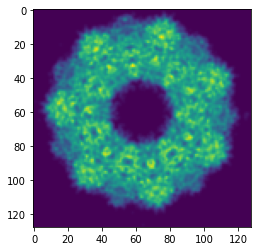

In [84]:
plt.imshow(Ixy)

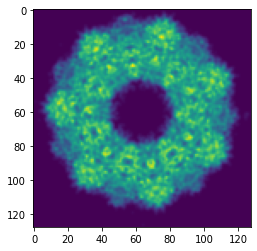

In [64]:
Icpp = np.loadtxt("Ical.txt")
plt.imshow(Icpp)

#Ixy.shape

In [ ]:
#Example: N atoms in random coordinates
N=4
n=3                         #Sigma times
res=128                    #Resolution
sigma=1*10**(-1)            #Standar deviation of the Gaussians
q=[0,0, 0, 0]

g=0.1


x_a=np.random.random(N) * 2 - 1   #x random atomic coordinates
y_a=np.random.random(N) * 2 - 1   #y random atomic coordinates
z_a=np.random.random(N) * 2 - 1   #y random atomic coordinates

#for atom in range(n_atoms):
#    print("ATOM", atom)
#    print("xsel=", list(i_sel (x,x_a[atom],sigma,n)))
#    print("ysel=", list(i_sel (y,y_a[atom],sigma,n)))
#    print("")

Ixy, x, y = I_calculated_2 (q, x_a, y_a, z_a, sigma, n, res)
#print(Ixy)
plt.imshow(Ixy)
plt.show()

noise=np.random.normal(0, g, Ixy.shape)
I=Ixy+noise
s=collective_variable(Ixy,I)
sgrad=gradient_s(Ixy, I, sigma, x, x_a)
sgrad3=gradient_s_2(Ixy, I, sigma, x, x_a)
print("s =", s)
print("sgrad_x =", sgrad)
print("sgrad_x_3 =", sgrad3)

In [51]:
#Importation of the 1xck's PDB to extract XYZ atomic coordinates
parser = PDB.PDBParser()
io = PDB.PDBIO()
struct = parser.get_structure('1xck','1xck.pdb')
x_atom=[]
y_atom=[]
z_atom=[]
for chains in struct:
    for chain in chains:
        for residue in chain:                             
            for atom in residue:
                x_atom.append(atom.get_vector()[0])
                y_atom.append(atom.get_vector()[1])
                z_atom.append(atom.get_vector()[2])
x_atom=np.array(x_atom)
y_atom=np.array(y_atom)
z_atom=np.array(z_atom)

/home/david/.local/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 56763.
  warnings.warn(
/home/david/.local/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 56800.
  warnings.warn(
/home/david/.local/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 56858.
  warnings.warn(
/home/david/.local/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 56887.
  warnings.warn(
/home/david/.local/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 56921.
  warnings.warn(
/home/david/.local/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 56979.
  w

In [48]:
np.savetxt("xcoord.txt", x_atom)
np.savetxt("ycoord.txt", y_atom)
np.savetxt("zcoord.txt", z_atom)